# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as dp
from IPython.display import Audio
from math import pi
from itertools import combinations
from librosa.util import peak_pick

# Roughness function

In [4]:
def sumVassilakis(freqs, amps):

  f_stack = np.array(list(combinations(freqs,2)))
  a_stack = np.array(list(combinations(amps,2)))
  if(len(f_stack) == 0):
    return 0
  b1, b2 = 3.5, 5.75
  xm = 0.24
  s1, s2 = 0.0207, 18.96
  s = xm / (s1 * np.min(f_stack, -1) + s2) 
  X = (a_stack[:,0]* a_stack[:,1]) ** 0.1 * 0.5
  Y = (2*a_stack[:,1]/np.sum(a_stack, -1)) ** 3.11
  Z = np.exp(-b1* s * np.abs(np.diff(f_stack)).squeeze()) -np.exp(-b2 * s * np.abs(np.diff(f_stack)).squeeze())
  return np.sum(X*Y*Z)

# Load audio file

In [5]:
x_mikka, sr_mikka = lb.load('xenakis_com_corte.wav', sr= 44100)
t_mikka = len(x_mikka)/sr_mikka # size of the audio in seconds

# Reasigned Spectrogram and peak peaking

In [6]:
# fft parameters

hop_length = 1024
win_length = 2048*4
nfft = 2048*4
center = True
reasign_times = False

In [7]:
# fft function

freq1, time1, spec1 = lb.reassigned_spectrogram(x_mikka, sr=sr_mikka, n_fft=nfft, hop_length=hop_length,center=center, reassign_times=reasign_times, win_length=win_length)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)


In [8]:
# peak peaking

p = lambda w: peak_pick(w, 2, 2, 5, 10, 0.01, 2)
peak1 = [p(w) for w in lb.amplitude_to_db(spec1.T,ref=np.max,amin=1e-8)]

# Roughness estimation

In [9]:
%%time
rough1 = []
for frame in range(len(spec1.T)):
  if peak1[frame].any():
    freqs = freq1.T[frame][peak1[frame]]
    amps = spec1.T[frame, peak1[frame]]
    rough1.append(sumVassilakis(freqs, amps))
  else:
    rough1.append(None)

CPU times: user 10min 31s, sys: 19.1 s, total: 10min 50s
Wall time: 10min 50s


# Plot roughness with audio segmentation

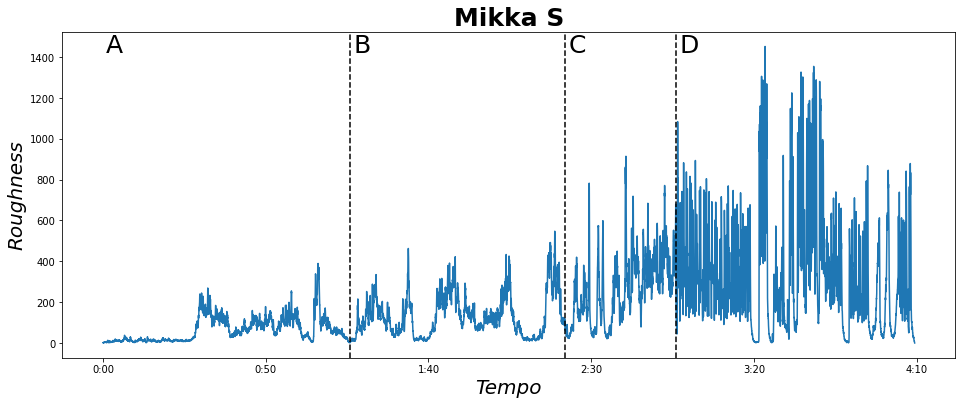

In [10]:
tempo_r = np.arange(0, t_mikka, t_mikka/len(rough1))

fig, ax = plt.subplots(figsize=(16,6))

plt.plot(tempo_r, rough1)#/np.max(rough1))

ax.xaxis.set_major_formatter(lb.display.TimeFormatter())

ax.set_title('Mikka S', size =25, fontweight = 'bold')
ax.set_ylabel('Roughness', size=20, fontstyle = 'italic')
ax.set_xlabel('Tempo', size=20, fontstyle = 'italic')

#seg = (76, 142, 176)

for t in [76, 142, 176]:
  plt.axvline(t, ls='--', color='black')


seg = [0, 76, 142, 176]
let = ['A', 'B', 'C', 'D']
for i in range(len(seg)):
    ax.text(seg[i]+1, 1425, let[i],  color='black', fontsize=25)

plt.show()